# This notebook contains the code to reproduce Figures 1 and A.1 in the paper

#### You might also want to refer to the documentation of [LIME](https://marcotcr.github.io/lime/tutorials/Tutorial%20-%20continuous%20and%20categorical%20features.html), [SHAP](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20XGBoost.html) and [DiCE](https://github.com/interpretml/DiCE)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split

import seaborn as sns

import xgboost

import shap
import lime

import dice_ml
from dice_ml.utils import helpers 

import facct_util as futil

%load_ext autoreload
%autoreload 2

## Load and prepare the data

In [3]:
X, y = shap.datasets.adult()

num_features = X.shape[1]
categorical_feature_indices = [1,3,4,5,6,7,11]

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [5]:
feature_names = list(X.columns)

cagegorical_features = [feature_names[i] for i in categorical_feature_indices]

cts_features = [f for f in feature_names if not f in cagegorical_features]

columns = [*feature_names, 'target' ]

In [6]:
len(feature_names), len(cagegorical_features) + len(cts_features)

(12, 12)

In [7]:
# take a look at the data
X_train.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
15282,36.0,4,7.0,0,14,0,4,1,0.0,0.0,40.0,39
24870,35.0,4,9.0,4,4,0,4,0,0.0,0.0,54.0,39
18822,38.0,4,13.0,4,1,0,4,0,0.0,0.0,50.0,39
26404,50.0,4,9.0,2,12,5,2,0,0.0,0.0,40.0,39
7842,68.0,6,11.0,2,10,4,4,1,0.0,2149.0,40.0,39


## Train a gradient boosted tree

In [8]:
gbtree = xgboost.XGBClassifier(n_estimators=300, max_depth=5, use_label_encoder=False, random_state=0)
gbtree.fit(X_train, Y_train)

[12:56:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=2,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [9]:
sklearn.metrics.accuracy_score(Y_test, gbtree.predict(X_test))

0.865806847842776

## Explanation Algorithms

### Prepare the data for the DiCE framwork

In [10]:
df_train = X_train.copy()
df_train.insert(12, 'outcome', Y_train)
df_test = X_test.copy()
df_train['outcome'] = df_train['outcome'].astype('bool')
for cf in cts_features:
    df_train[cf] = df_train[cf].astype('float32')

d = dice_ml.Data(dataframe=df_train, continuous_features=cts_features, outcome_name='outcome', enable_categorical=True)

X_train_dice = d.normalize_data(d.one_hot_encode_data(X_train))
X_test_dice = d.normalize_data(d.one_hot_encode_data(X_test))

In [11]:
from collections import defaultdict

# LIME
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, 
                                                        feature_names = X.columns.values, 
                                                        class_names=["<50k", ">50k"], 
                                                        categorical_features = categorical_feature_indices, 
                                                        categorical_names = defaultdict(lambda : 'default'), kernel_width=3) 

# Shap
shap_explainer = shap.TreeExplainer(gbtree)

# Interventional Shap
interventional_shap_explainer = shap.TreeExplainer(gbtree, feature_perturbation="interventional", data=X_train)

# DiCE
m = dice_ml.Model(gbtree, backend="sklearn", model_type='classifier')
counterfactual_explainer = dice_ml.Dice(d, m, method="random")

## Generate Plots: Figures 1 and A.1 in the paper

In [12]:
sns.set_style("whitegrid")
sns.set_context("notebook", rc={'axes.linewidth': 3, 'grid.linewidth': 1.5},  font_scale=3.5)

y_axis_labels = [f'F{i}' for i in range(1, 13)]

--------------------- Example 0----------------------
Predicted Probabilities:  [[0.9934773  0.00652269]]  Predicted Class:  0


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
100%|██████████| 1/1 [00:04<00:00,  4.66s/it]
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


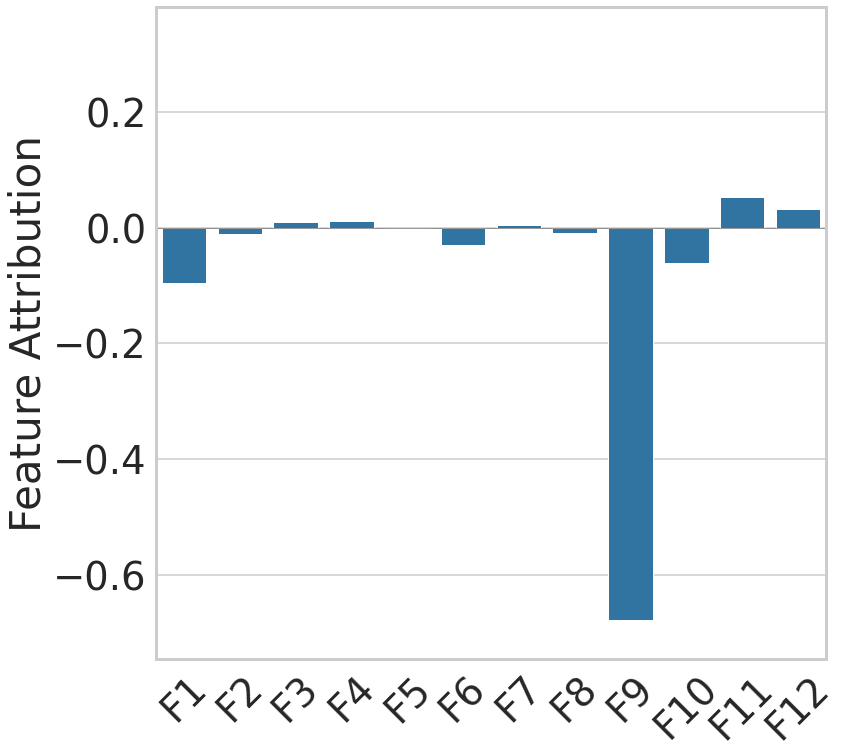

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


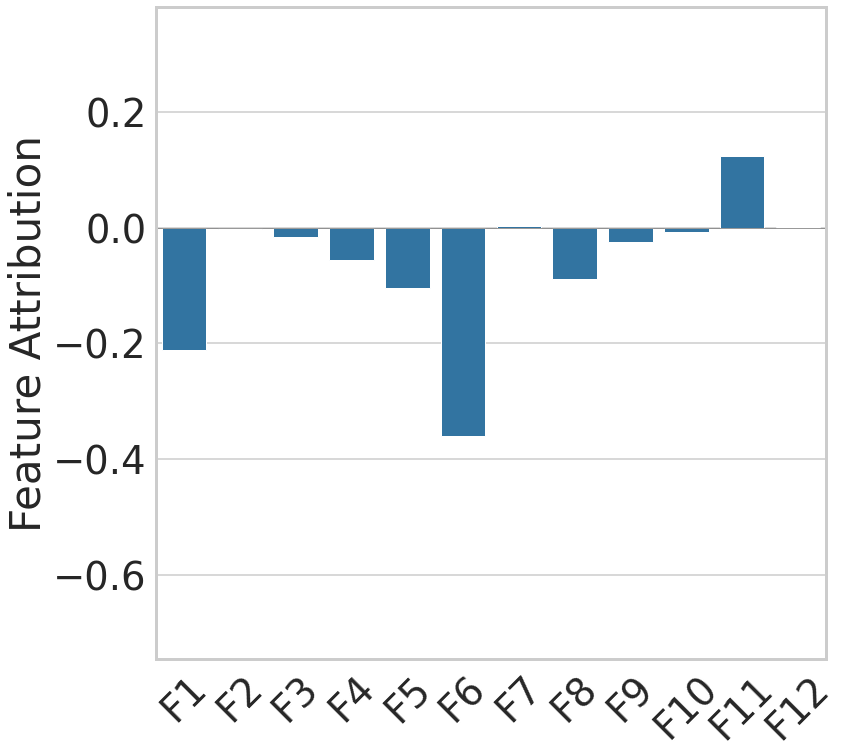

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


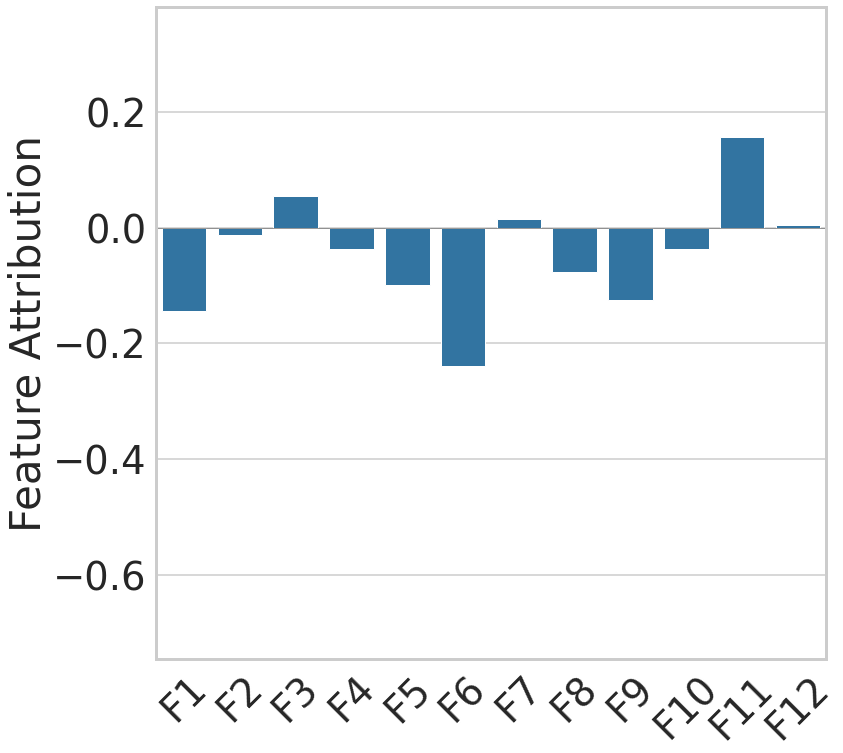

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


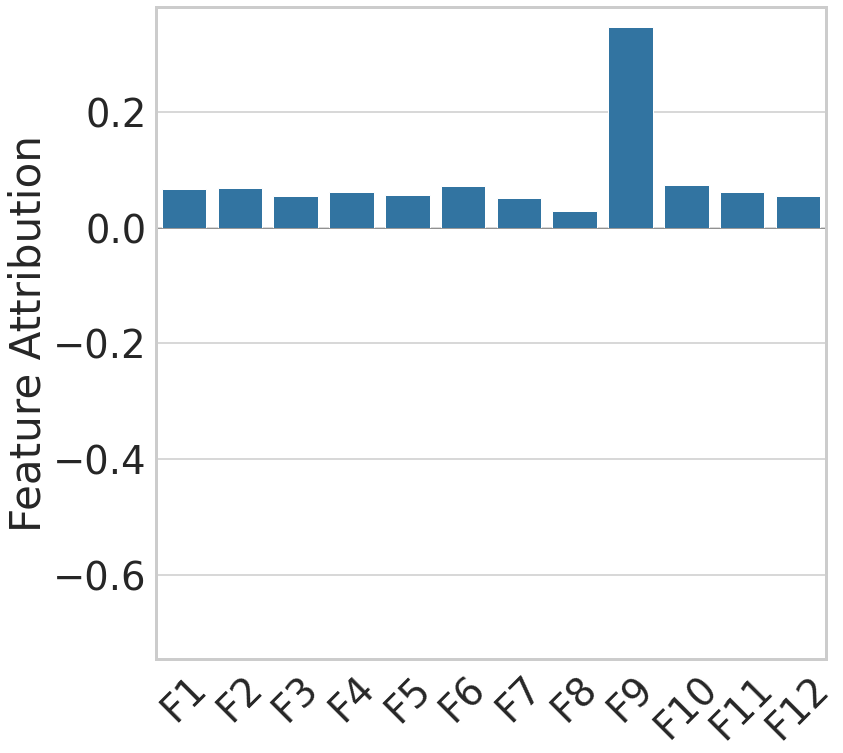

--------------------- Example 1----------------------
Predicted Probabilities:  [[0.9749317  0.02506828]]  Predicted Class:  0


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
100%|██████████| 1/1 [00:04<00:00,  4.42s/it]
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


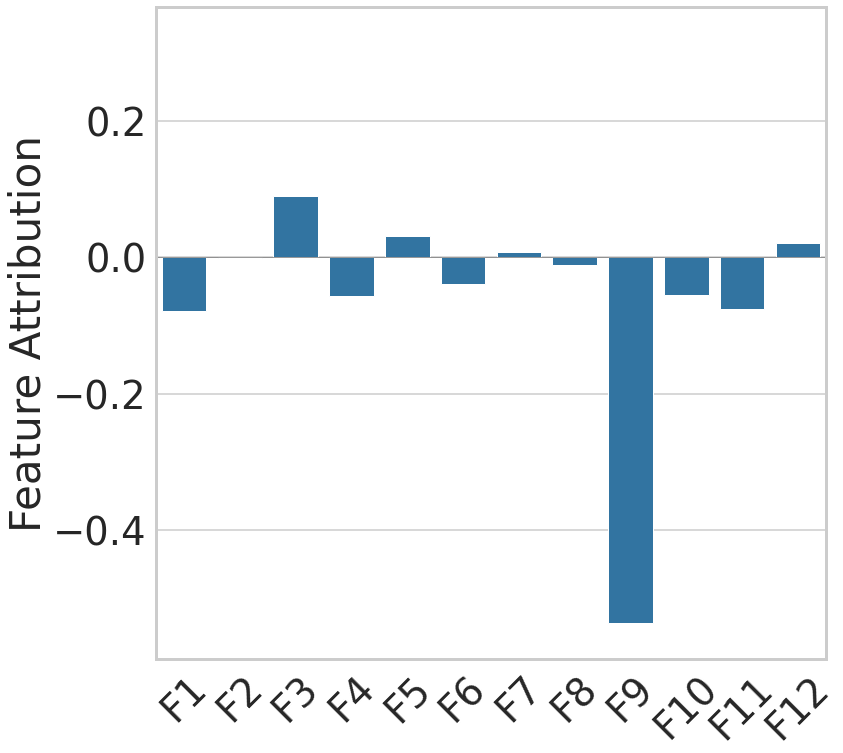

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


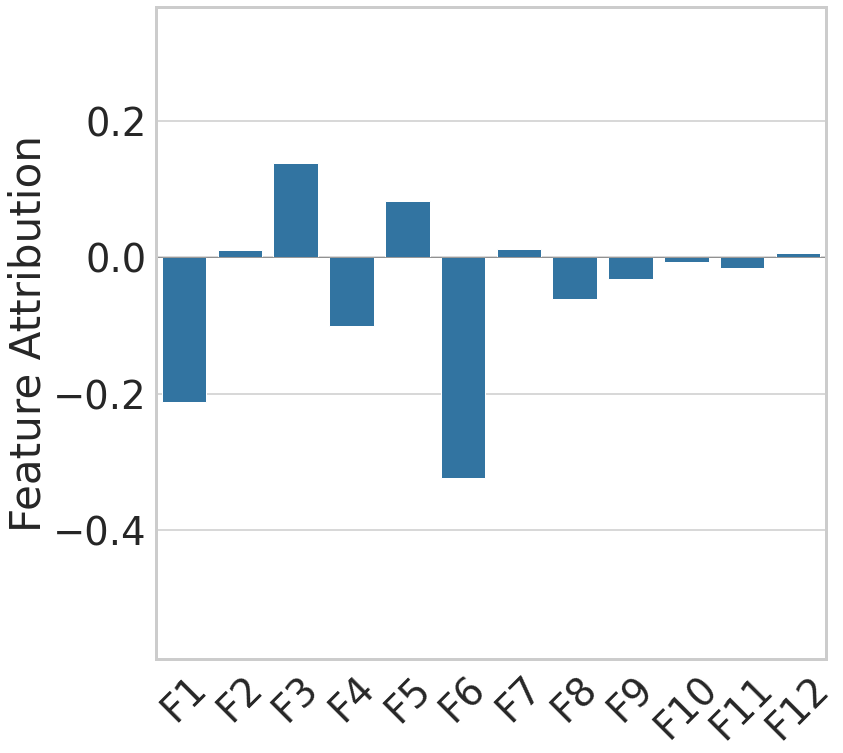

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


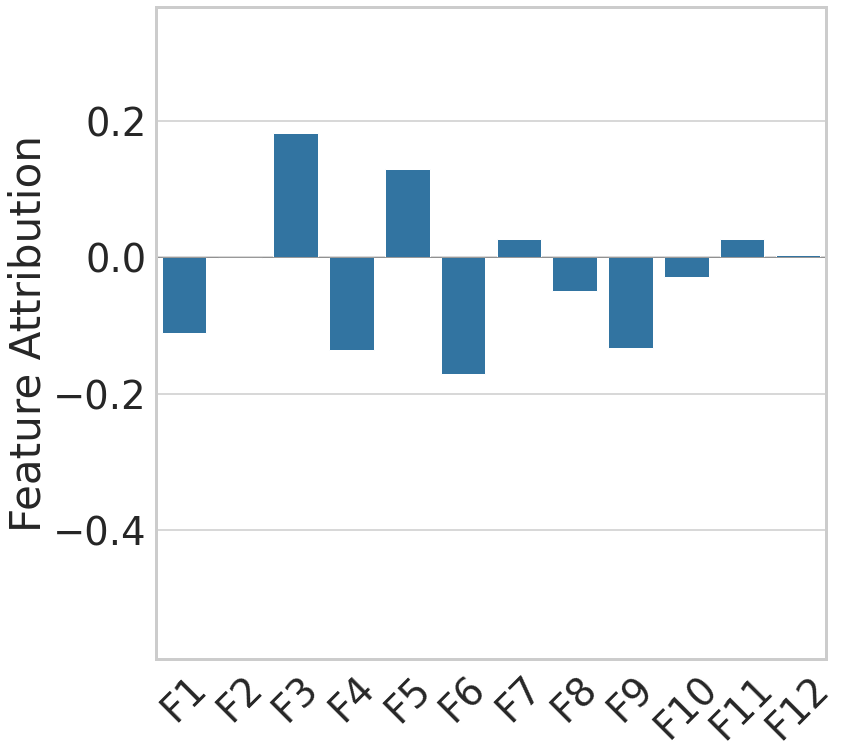

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


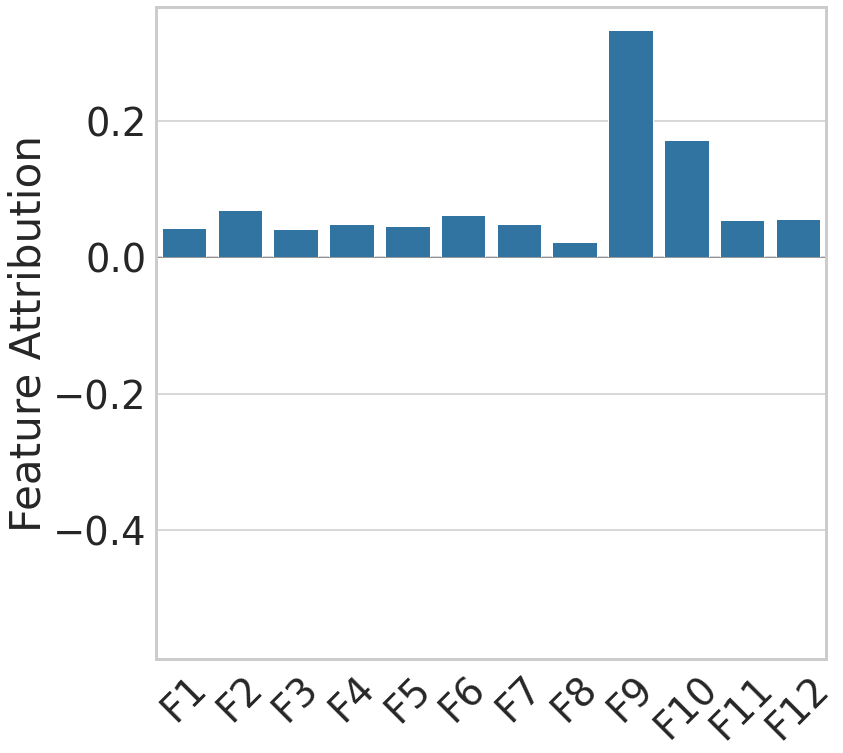

--------------------- Example 2----------------------
Predicted Probabilities:  [[0.8438307  0.15616928]]  Predicted Class:  0


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
100%|██████████| 1/1 [00:04<00:00,  4.77s/it]
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


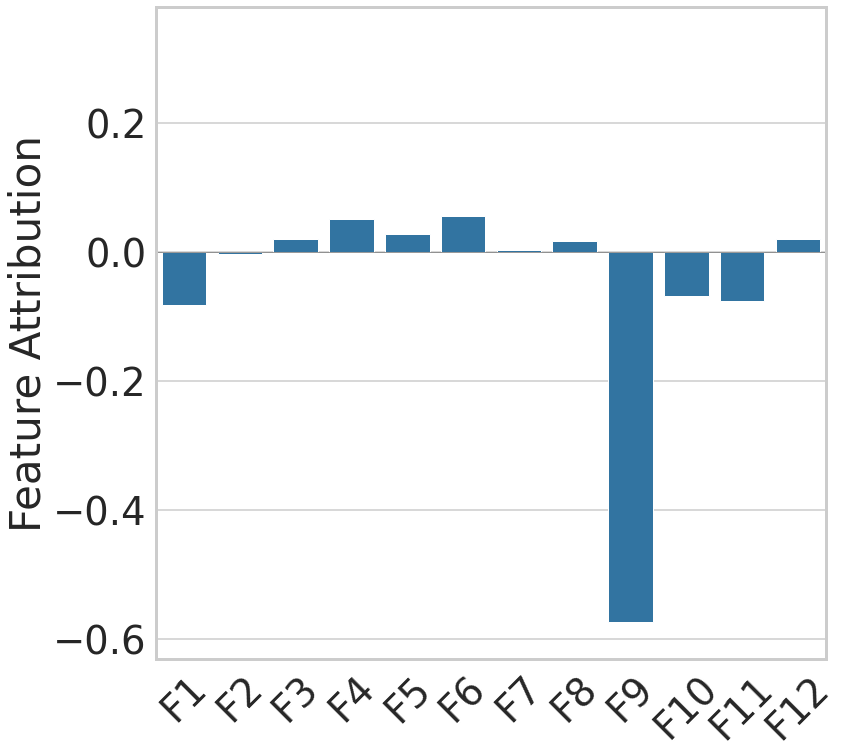

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


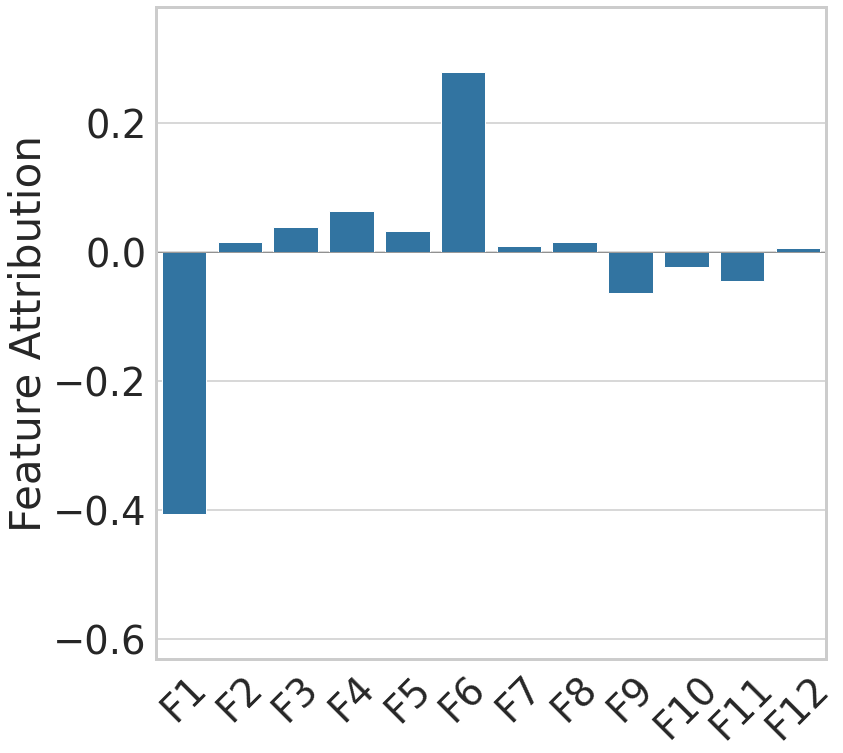

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


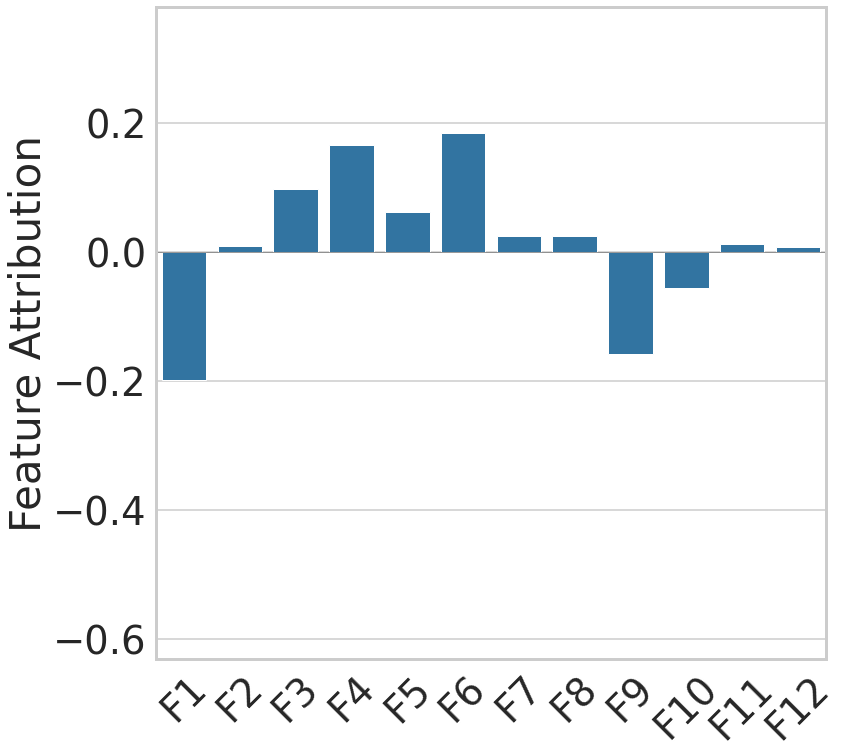

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


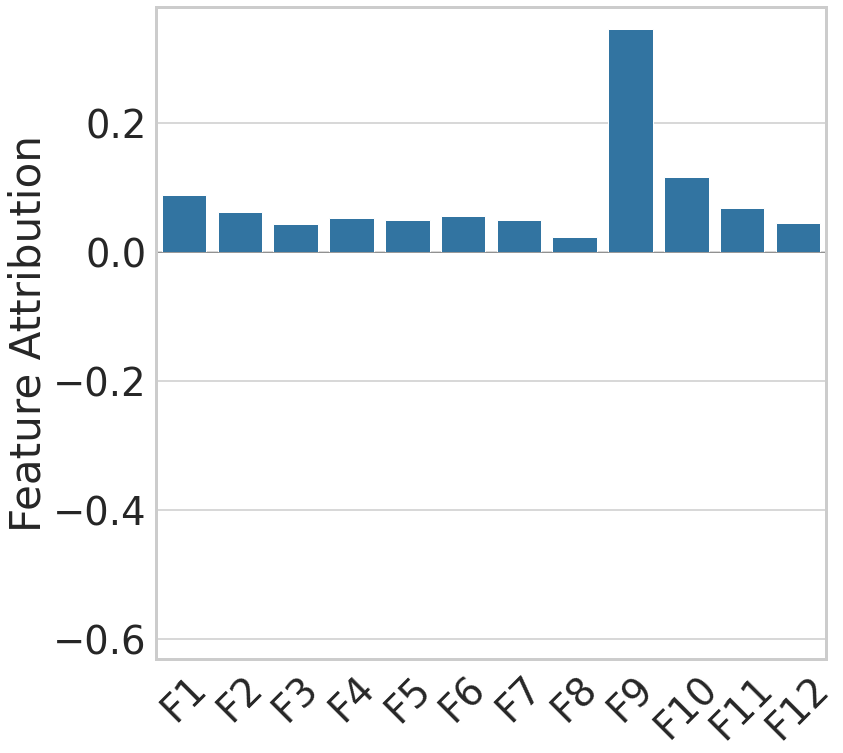

--------------------- Example 3----------------------
Predicted Probabilities:  [[0.18437648 0.8156235 ]]  Predicted Class:  1


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
100%|██████████| 1/1 [00:04<00:00,  4.51s/it]
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


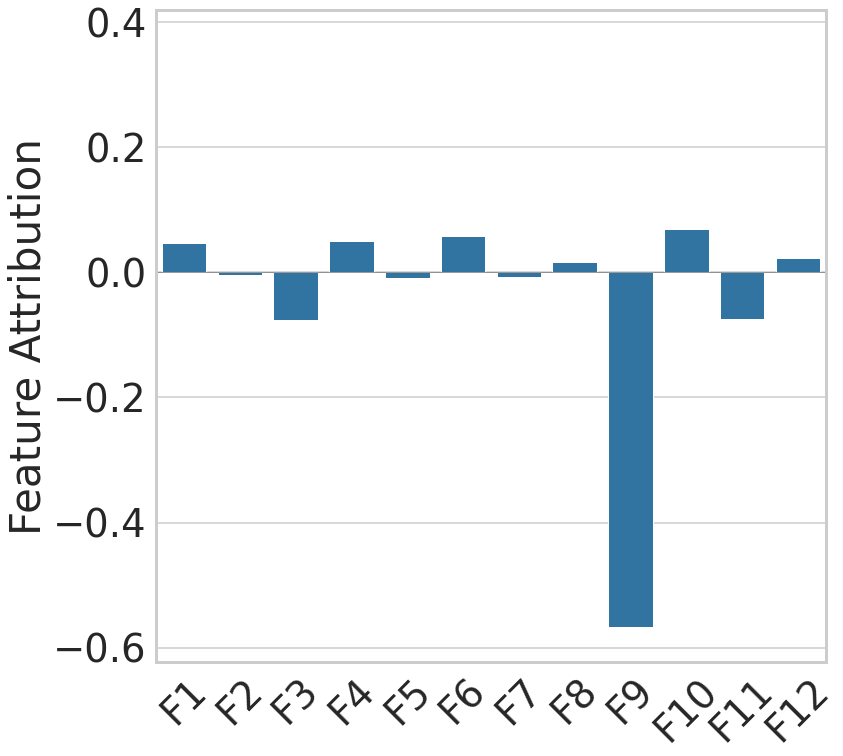

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


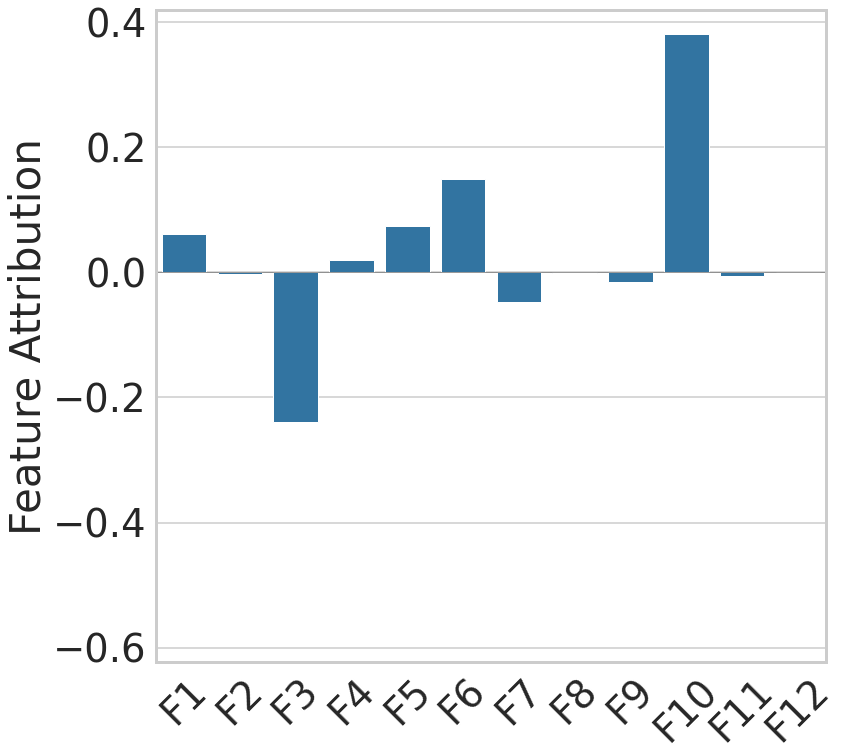

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


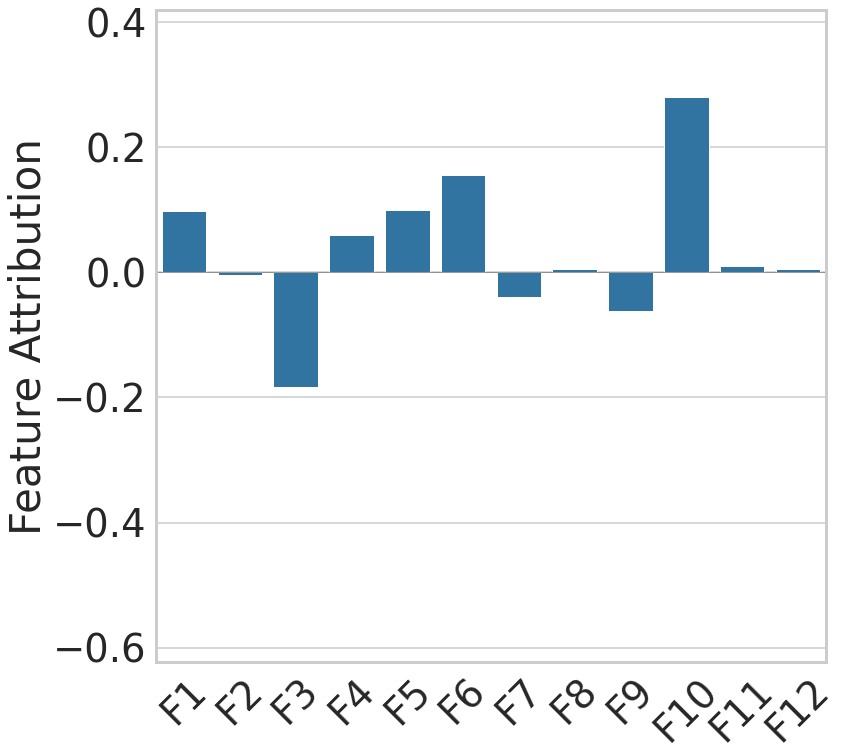

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


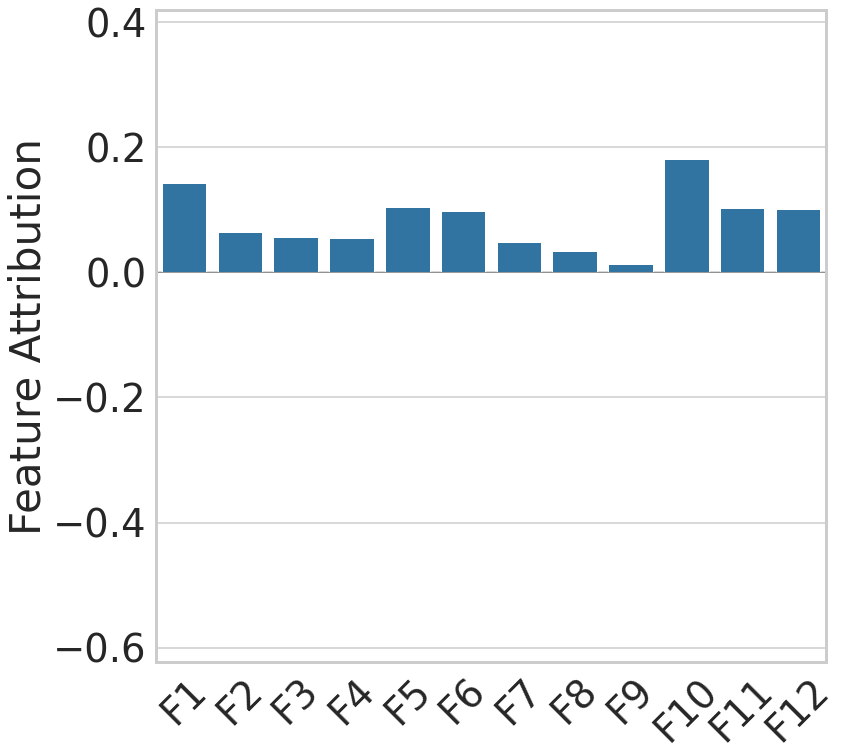

--------------------- Example 4----------------------
Predicted Probabilities:  [[0.68264717 0.31735283]]  Predicted Class:  0


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
100%|██████████| 1/1 [00:04<00:00,  4.97s/it]
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


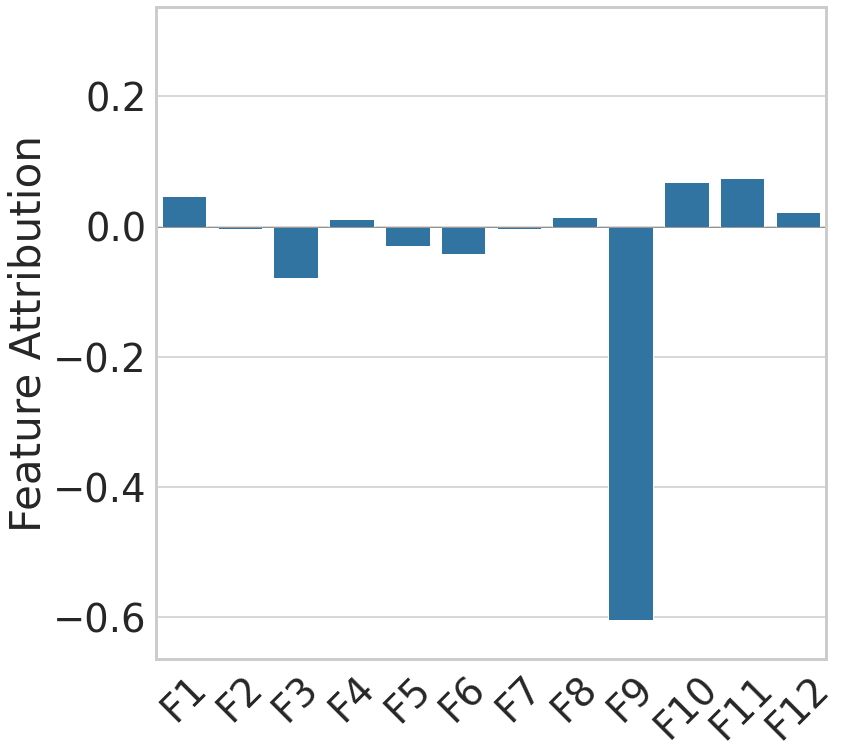

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


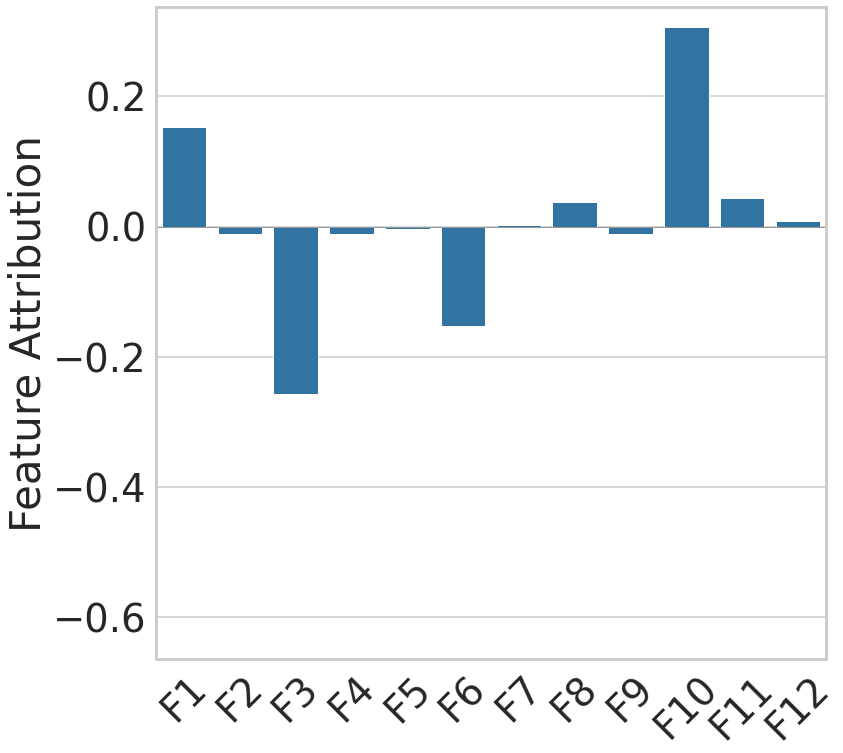

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


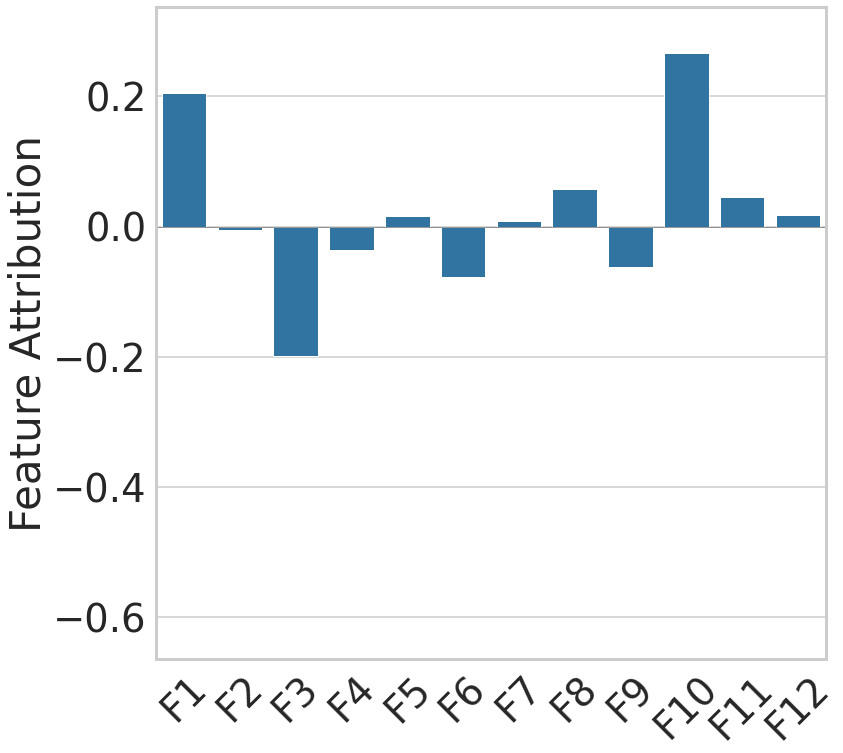

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


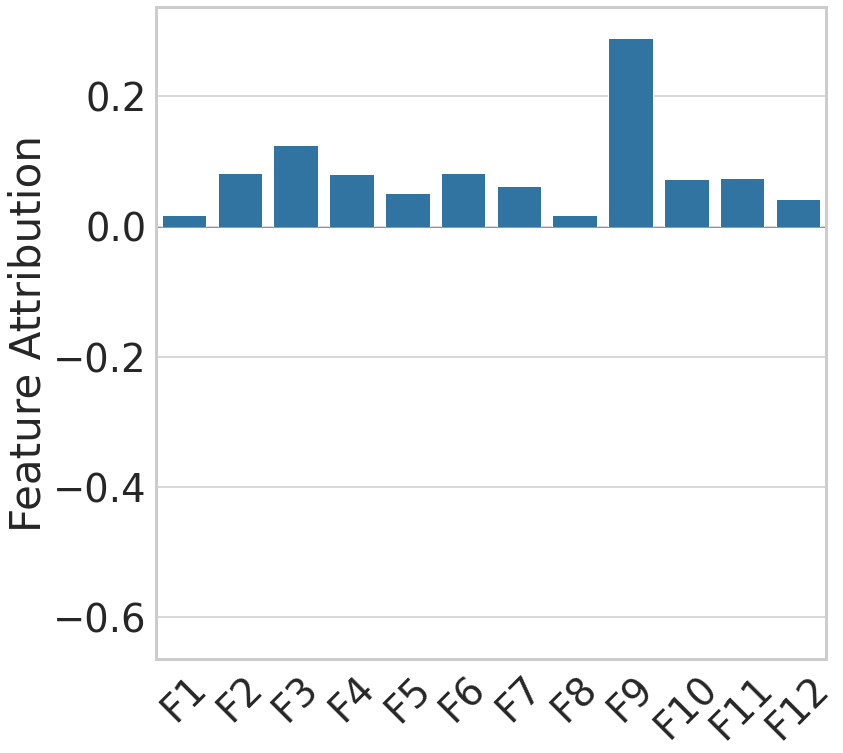

--------------------- Example 5----------------------
Predicted Probabilities:  [[0.7914752  0.20852484]]  Predicted Class:  0


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
100%|██████████| 1/1 [00:04<00:00,  4.73s/it]
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


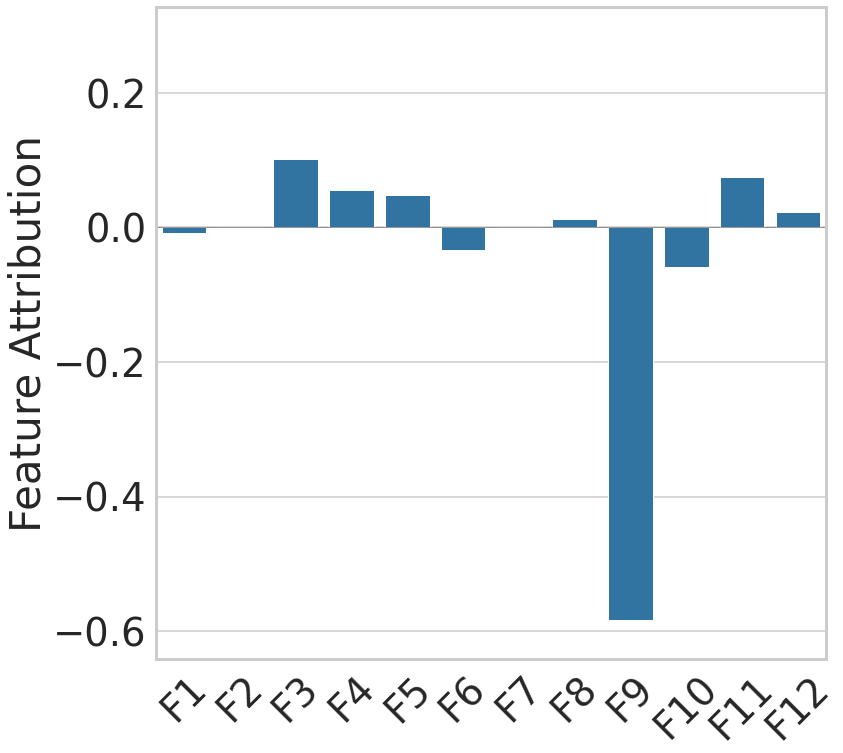

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


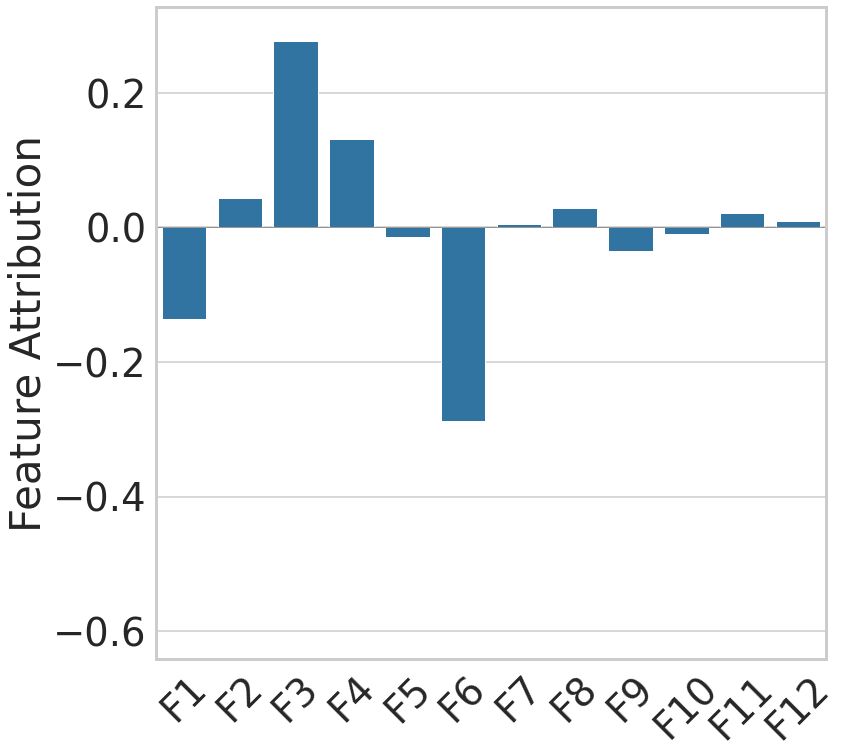

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


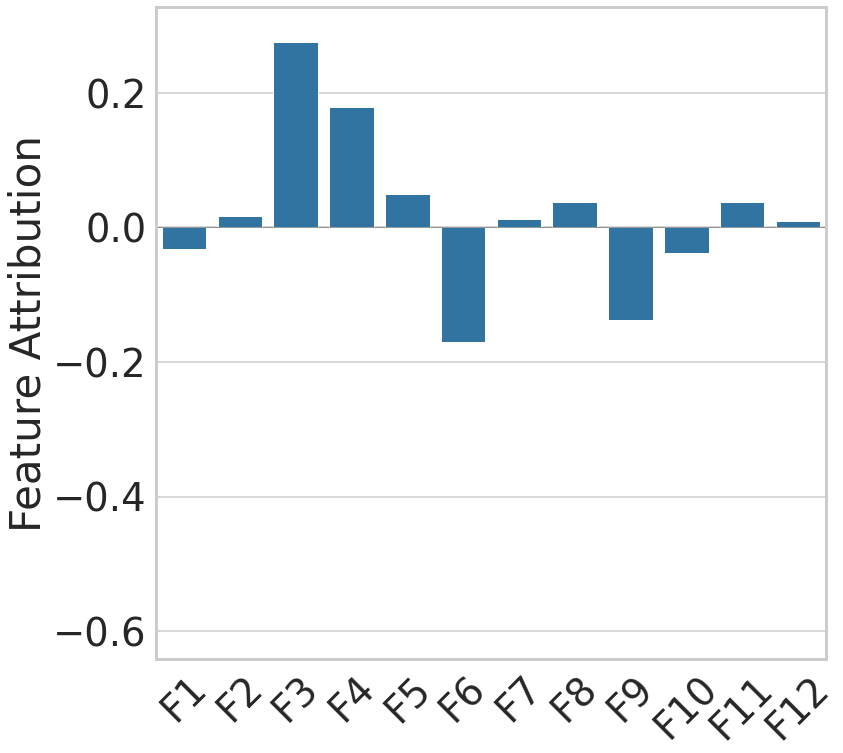

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


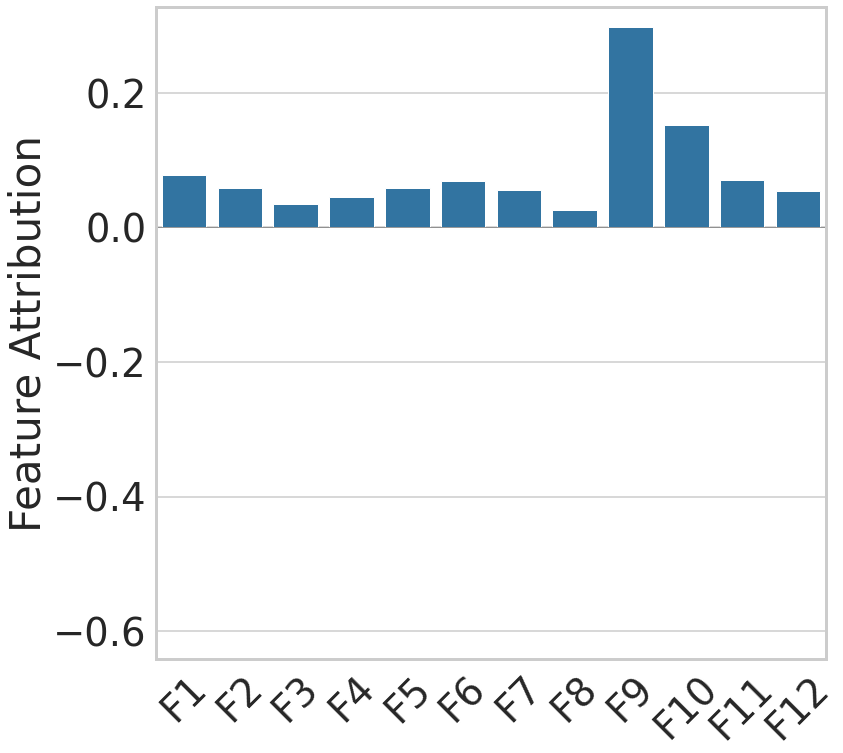

In [17]:
for i in range(6):
    x = X_test.values[i, :]
    print(f'--------------------- Example {i}----------------------')
    probabilities = gbtree.predict_proba(x.reshape(1, -1))
    top_class = probabilities.argmax()
    print('Predicted Probabilities: ', probabilities, ' Predicted Class: ', top_class)

    # Lime
    exp = lime_explainer.explain_instance(x, gbtree.predict_proba, num_features=12)
    lime_attributions = futil.extract_lime_attributions(exp, X.columns.values)
    lime_attributions = lime_attributions / np.linalg.norm(lime_attributions, 1)
    
    # Shap
    shap_values = shap_explainer.shap_values(x.reshape(1, 12))
    shap_attributions = shap_values[0] / np.linalg.norm(shap_values[0], 1)
    
    # Interventional Shap
    interventional_shap_values = interventional_shap_explainer.shap_values(x.reshape(1, 12))
    interventional_shap_attributions = interventional_shap_values[0] / np.linalg.norm(interventional_shap_values[0], 1)
    
    # Dice
    e1 = counterfactual_explainer.generate_counterfactuals(X_test[i:i+1], total_CFs=500, desired_range=None,
                                      desired_class="opposite",
                                      permitted_range=None, features_to_vary="all", random_seed=0)

    imp = counterfactual_explainer.local_feature_importance(X_test[i:i+1], cf_examples_list=e1.cf_examples_list)
    cf_attributions = [imp.local_importance[0][f] for f in X.columns.values]
    cf_attributions = cf_attributions / np.linalg.norm(cf_attributions, 1)

    # Plots
    ymin = 1.1*min(lime_attributions.min(), shap_attributions.min(), cf_attributions.min())
    ymax = 1.1*max(lime_attributions.max(), shap_attributions.max(), cf_attributions.max())
    
    futil.viz_feature_attributions(lime_attributions, y_axis_labels, None, ylim=(ymin, ymax))
    plt.savefig(f'figures/adults/{i}_lime.pdf', bbox_inches='tight', facecolor='white')
    plt.show()
    futil.viz_feature_attributions(shap_attributions, y_axis_labels, None, ylim=(ymin, ymax))
    plt.savefig(f'figures/adults/{i}_shap.pdf', bbox_inches='tight', facecolor='white')
    plt.show()
    futil.viz_feature_attributions(interventional_shap_attributions, y_axis_labels, None, ylim=(ymin, ymax))
    plt.savefig(f'figures/adults/{i}_interventional_shap.pdf', bbox_inches='tight', facecolor='white')
    plt.show()
    futil.viz_feature_attributions(cf_attributions, y_axis_labels, None, ylim=(ymin, ymax))
    plt.savefig(f'figures/adults/{i}_cf.pdf', bbox_inches='tight', facecolor='white')
    plt.show()